In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

import datetime

In [2]:
def rgb_to_greyscale(image):
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

In [8]:
patch_size = 56
stride = 56
latent_dim = 128

In [5]:
# "load" VAE

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_4[0][0]                   
____________________________________________________________________________________________

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = 0.01 * reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [14]:
model_version = "0.0.0.9_lr0.0001_50moreepochs"
vae.load_weights('/scratch/image_datasets/2_for_learned_brief/ready/vae_' + model_version + '.h5')

In [76]:
image = imageio.imread("/home/niaki/Downloads/Lenna.png")
image = rgb_to_greyscale(image)
image_height = image.shape[0]
image_width = image.shape[1]

In [77]:
image_reconstr = np.zeros((image.shape))

In [78]:
# for all the patches in an image with stride $stride
for y in range(0, image_width - patch_size + 1, stride):
    for x in range(0, image_height - patch_size + 1, stride):
        patch = image[x: x + patch_size, y: y + patch_size]
        patch = np.expand_dims(patch, axis=-1)
        patch = np.expand_dims(patch, axis=0)
        patch = patch / 255.
        patch_reconstr = decoder.predict_on_batch(encoder.predict_on_batch(np.array(patch)))
        image_reconstr[x: x + patch_size, y: y + patch_size] = patch_reconstr[0, :, :, 0]

Lossy conversion from float64 to uint8. Range [25.5566, 244.9959]. Convert image to uint8 prior to saving to suppress this warning.


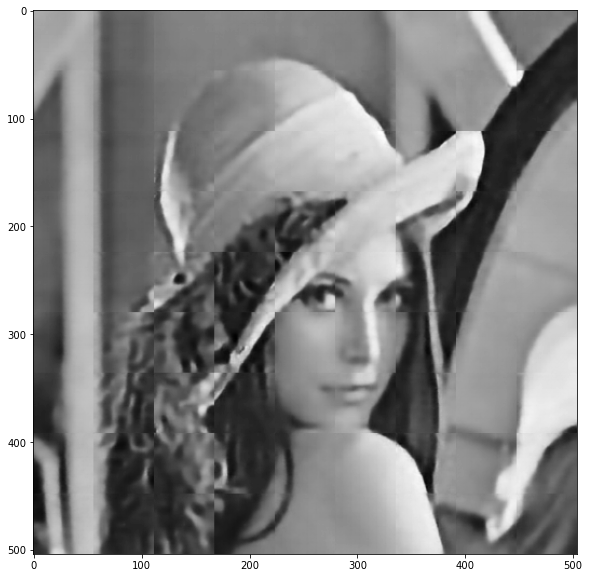

In [79]:
datetime_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
crop_height = len(range(0, image_height - patch_size + 1, stride)) * patch_size
crop_width = len(range(0, image_width - patch_size + 1, stride)) * patch_size

image_crop = image[: crop_height, : crop_width]
image_reconstr_crop = np.array(image_reconstr[: crop_height, : crop_width] * 255, dtype=np.uint8)


imageio.imsave('/home/niaki/Downloads/image_vae' + datetime_str + "_original.png", image_crop)
imageio.imsave('/home/niaki/Downloads/image_vae' + datetime_str + "_reconstr.png", image_reconstr_crop)

plt.figure(figsize=(20,10))
plt.imshow(image_reconstr_crop, cmap="gray")